In [50]:
#!conda env list

In [51]:
#!conda run -p /home/njm12/ATMS_523/envs/xarray-climate python -m ipykernel install --user --name xarray-climate --display-name "Python (xarray-climate)"

In [52]:
import sys
print(sys.executable)

/home/njm12/ATMS_523/envs/xarray-climate/bin/python


In [53]:
# Cell 1: Imports and environment setup
import os
import glob
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point, box
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
import matplotlib.patches as patches

#Interactive Tool Imports
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"  # or "notebook_connected"

#Statistical Significance Testing Imports
from scipy.stats import kruskal
import itertools

# Allow OGR to accept non-closed rings
os.environ["OGR_GEOMETRY_ACCEPT_UNCLOSED_RING"] = "YES"

# --- Configuration ---
base_dir = "/home/njm12/ATMS_596/Land-Water"
target_crs = "EPSG:26915"  # UTM Zone 15
tornado_csv = "/home/njm12/ATMS_596/1950-2024_actual_tornadoes.csv"  # Updated with my CSV path
states_of_interest = ["IL", "IA", "MO"]
min_date = pd.to_datetime("1950-01-01")  # Start from first date in dataset

In [54]:
# Cell 2: Load UMESC Mississippi River shapefiles
pool_dirs = [f"Pool {p}" for p in range(12, 27) if p != 23] + ["Open River", "Open River 2"]
gdfs = []

for pool_dir in pool_dirs:
    if "Open River" in pool_dir:
        shp_files = glob.glob(os.path.join(base_dir, pool_dir, "*z16n83.shp"))
        local_crs = "EPSG:26916"
    else:
        shp_files = glob.glob(os.path.join(base_dir, pool_dir, "*z15n83.shp"))
        local_crs = target_crs

    for f in shp_files:
        gdf = gpd.read_file(f)
        if gdf.crs is None:
            gdf = gdf.set_crs(local_crs)
        gdf = gdf.to_crs(target_crs)
        gdf["POOL"] = pool_dir
        gdfs.append(gdf)

umesc_all = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=target_crs)
print("UMESC combined:", umesc_all.shape)
print(f"Pools included: {sorted(umesc_all['POOL'].unique())}")

UMESC combined: (8050, 14)
Pools included: ['Open River', 'Open River 2', 'Pool 12', 'Pool 13', 'Pool 14', 'Pool 15', 'Pool 16', 'Pool 17', 'Pool 18', 'Pool 19', 'Pool 20', 'Pool 21', 'Pool 22', 'Pool 24', 'Pool 25', 'Pool 26']


In [55]:
# --- Derive approximate river centerline from UMESC polygons ---
# Fix invalid polygons before union
umesc_all["geometry"] = umesc_all.geometry.make_valid()
umesc_all["geometry"] = umesc_all.buffer(0)  # Ensures clean geometry

# Use the new 'union_all()' method (replaces deprecated unary_union)
river_union = umesc_all.union_all()

# Derive approximate river centerline
river_centerline = gpd.GeoSeries([river_union], crs=target_crs).buffer(-200).boundary
river_centerline = gpd.GeoDataFrame(geometry=river_centerline, crs=target_crs)
print("River centerline constructed from UMESC polygons.")

River centerline constructed from UMESC polygons.


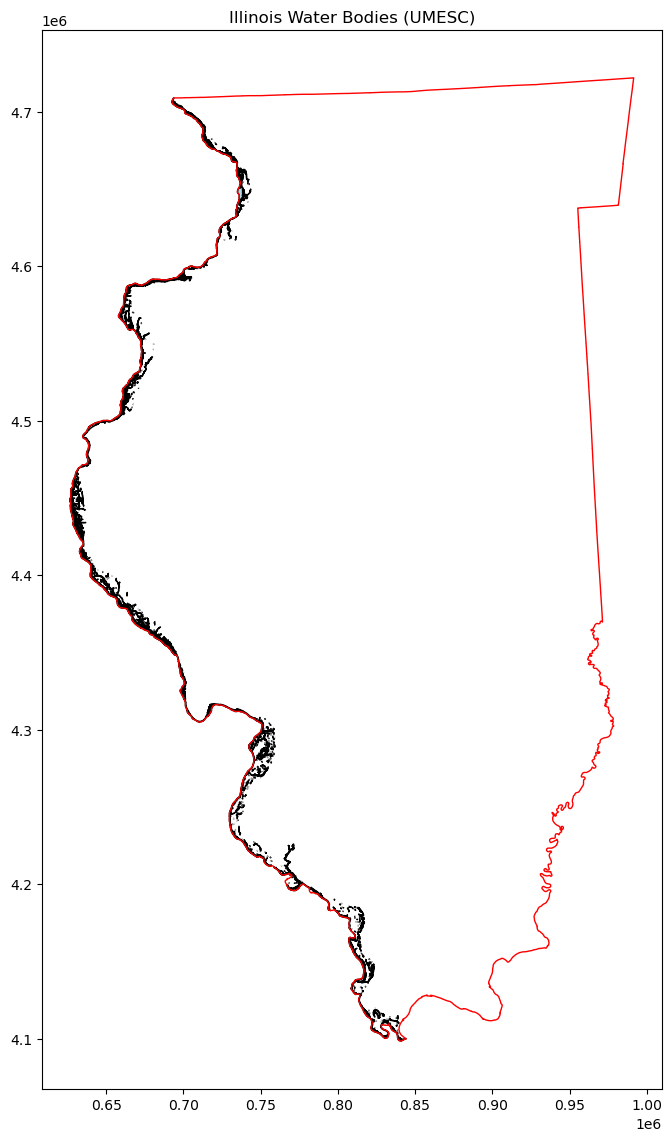

In [56]:
# Cell 3: Extract Illinois water portion
url = "https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip"
states = gpd.read_file(url)
illinois = states[states["NAME"] == "Illinois"].to_crs(target_crs)

# Filter water polygons only
water_only = umesc_all[umesc_all["LAND_WATER"] == "Water"].copy()
water_il = gpd.clip(water_only, illinois)

# Plot check
ax = water_il.plot(figsize=(8, 14), color="lightblue", edgecolor="k")
illinois.boundary.plot(ax=ax, color="red", linewidth=1)
ax.set_title("Illinois Water Bodies (UMESC)")
plt.show()

In [57]:
print("Number of invalid geometries in water_only:", (~water_only.is_valid).sum())
print("Invalid geometries indices:", water_only[~water_only.is_valid].index)

Number of invalid geometries in water_only: 0
Invalid geometries indices: Index([], dtype='int64')


In [58]:
# Fix invalid geometries using buffer(0) - only if needed
water_only.loc[~water_only.is_valid, "geometry"] = water_only.loc[~water_only.is_valid, "geometry"].buffer(0)

# Verify
print("Invalid geometries after fix:", (~water_only.is_valid).sum())

Invalid geometries after fix: 0


In [59]:
# Ensure Illinois geometry is valid
illinois["geometry"] = illinois["geometry"].buffer(0)

# Perform clip
water_il = gpd.clip(water_only, illinois)

print("Clipped water shapes:", water_il.shape)

Clipped water shapes: (2876, 14)


In [60]:
# Combine all Illinois water polygons into a single geometry
river_il = water_il.union_all()
print(type(river_il))
print("Bounds of Illinois river section:", river_il.bounds)

<class 'shapely.geometry.multipolygon.MultiPolygon'>
Bounds of Illinois river section: (626594.3664122473, 4098437.22724262, 844182.0029604747, 4708927.272888837)


In [61]:
# Automatic date parsing
tornadoes = pd.read_csv(tornado_csv, parse_dates=['date'])

# Filter by states, EF-scale, and date (can include stronger tornadoes on map, if necessary / min_date will likely be changed)
tornadoes = tornadoes[
    tornadoes['st'].isin(states_of_interest) &
    tornadoes['mag'].isin([0, 1, 2, 3, 4, 5]) &
    (tornadoes['date'] >= min_date)
]

print("Filtered tornadoes:", tornadoes.shape)
tornadoes

Filtered tornadoes: (8287, 29)


om    yr  mo  dy       date      time  tz  st  stf  stn  ...  \
6         198  1950  12   2 1950-12-02  15:00:00   3  IL   17    7  ...   
7         199  1950  12   2 1950-12-02  16:00:00   3  IL   17    8  ...   
9         201  1950  12   2 1950-12-02  17:30:00   3  IL   17    9  ...   
11          5  1950   1  25 1950-01-25  19:30:00   3  MO   29    2  ...   
12          6  1950   1  25 1950-01-25  21:00:00   3  IL   17    3  ...   
...       ...   ...  ..  ..        ...       ...  ..  ..  ...  ...  ...   
71664  624857  2024   8  15 2024-08-15  22:06:00   3  IL   17    0  ...   
71687  624880  2024   8  30 2024-08-30  11:45:00   3  IL   17    0  ...   
71712  624820  2024   8   5 2024-08-05  20:57:00   3  IA   19    0  ...   
71713  624821  2024   8   5 2024-08-05  21:11:00   3  IA   19    0  ...   
71714  624822  2024   8   5 2024-08-05  21:29:00   3  IA   19    0  ...   

         len  wid  ns  sn  sg   f1   f2  f3  f4  fc  
6      18.80   50   1   1   1  119  117   0   0   0  
7      18.00  200   1   1   1  119    5   0   0   0  
9       9.60   50   1   1   1  157    0   0   0   0  
11      2.30  300   1   1   1   93    0   0   0   0  
12      0.10  100   1   1   1   91    0   0   0   0  
...      ...  ...  ..  ..  ..  ...  ...  ..  ..  ..  
71664   3.20   50   1   1   1  175    0   0   0   0  
71687   0.08   20   1   1   1  157    0   0   0   0  
71712   0.33   30   1   1   1  191    0   0   0   0  
71713   0.98   80   1   1   1  191    0   0   0   0  
71714   3.80   50   1   1   1    5    0   0   0   0  

[8287 rows x 29 columns]

In [62]:
# Remove any rows with missing or invalid coordinates
coord_cols = ['slon', 'slat', 'elon', 'elat']
tornadoes = tornadoes.dropna(subset=coord_cols)

# Remove out-of-bounds or unrealistic coordinates
tornadoes = tornadoes[
    (tornadoes['slon'].between(-180, 180)) &
    (tornadoes['elon'].between(-180, 180)) &
    (tornadoes['slat'].between(-90, 90)) &
    (tornadoes['elat'].between(-90, 90))
]
print("After coordinate cleaning:", tornadoes.shape)

After coordinate cleaning: (8287, 29)


In [63]:
# --- Fix 1: Convert positive longitudes (U.S. longitudes are negative west of Greenwich) ---
tornadoes['slon'] = tornadoes['slon'].apply(lambda x: -x if x > 0 else x)
tornadoes['elon'] = tornadoes['elon'].apply(lambda x: -x if x > 0 else x)

# --- Fix 2: Remove zero or missing coordinates (invalid positions) ---
tornadoes.loc[tornadoes['slat'] == 0, 'slat'] = np.nan
tornadoes.loc[tornadoes['elat'] == 0, 'elat'] = np.nan
tornadoes.loc[tornadoes['slon'] == 0, 'slon'] = np.nan
tornadoes.loc[tornadoes['elon'] == 0, 'elon'] = np.nan

# Drop rows with NaNs after cleaning
tornadoes = tornadoes.dropna(subset=['slon', 'slat', 'elon', 'elat']).copy()

# Check coordinate ranges again
print("Longitude range (fixed):", tornadoes[['slon', 'elon']].min().min(), "to", tornadoes[['slon', 'elon']].max().max())
print("Latitude range (fixed):", tornadoes[['slat', 'elat']].min().min(), "to", tornadoes[['slat', 'elat']].max().max())

Longitude range (fixed): -96.6 to -85.23
Latitude range (fixed): 36.0022 to 45.5


In [64]:
from shapely.geometry import LineString, Point
import geopandas as gpd

# Create LineString or Point geometries
def make_geom(row):
    if pd.isna(row['elon']) or pd.isna(row['elat']) or \
       (row['elon'] == row['slon'] and row['elat'] == row['slat']):
        return Point(row['slon'], row['slat'])
    else:
        return LineString([(row['slon'], row['slat']), (row['elon'], row['elat'])])

tornadoes['geometry'] = tornadoes.apply(make_geom, axis=1)

# Convert to GeoDataFrame
tornado_gdf = gpd.GeoDataFrame(tornadoes, geometry='geometry', crs="EPSG:4326")

# Reproject to match water shapefile CRS
tornado_gdf = tornado_gdf.to_crs(target_crs)

print("Tornado geometries rebuilt")
print("Geometry types:", tornado_gdf.geometry.geom_type.value_counts())
print("Bounds:", tornado_gdf.total_bounds)

Tornado geometries rebuilt
Geometry types: LineString    4739
Point         1054
Name: count, dtype: int64
Bounds: [ 205367.62901075 3987738.95756939 1160467.39964418 5041734.47457036]


In [65]:
# Fix invalid water polygons
water_il['geometry'] = water_il['geometry'].buffer(0)

# Merge into single geometry
river_il_geom = water_il.geometry.union_all()  # or .union_all() if using new shapely

# Ensure the final geometry is valid
from shapely.validation import make_valid
river_il_geom = make_valid(river_il_geom)

In [66]:
# Buffer by 10 km
river_buffer = river_il_geom.buffer(10000)  # adjust as needed

# Check intersections with buffer
tornado_gdf['crosses_river'] = tornado_gdf.intersects(river_buffer)
crossings = tornado_gdf[tornado_gdf['crosses_river']]

print("Total tornadoes crossing Mississippi River or intersecting buffered zone:", crossings.shape[0])
print("Counts by EF-scale:\n", crossings['mag'].value_counts())

Total tornadoes crossing Mississippi River or intersecting buffered zone: 372
Counts by EF-scale:
 mag
0    124
1    122
2     79
3     37
4     10
Name: count, dtype: int64


In [67]:
#Quick sanity check to make sure the river buffer is actually or approximately ~10 km (and in the right units). 

from shapely.ops import nearest_points

# Pick a point on the river geometry
river_point = river_il_geom.representative_point()

# Pick nearest point on the buffer boundary
buffer_boundary = river_buffer.boundary
nearest = nearest_points(river_point, buffer_boundary)[1]

# Compute distance in meters (UTM units)
distance_m = river_point.distance(nearest)
distance_km = distance_m / 1000
print(f"Distance from river to buffer boundary: {distance_km:.2f} km")

Distance from river to buffer boundary: 10.67 km


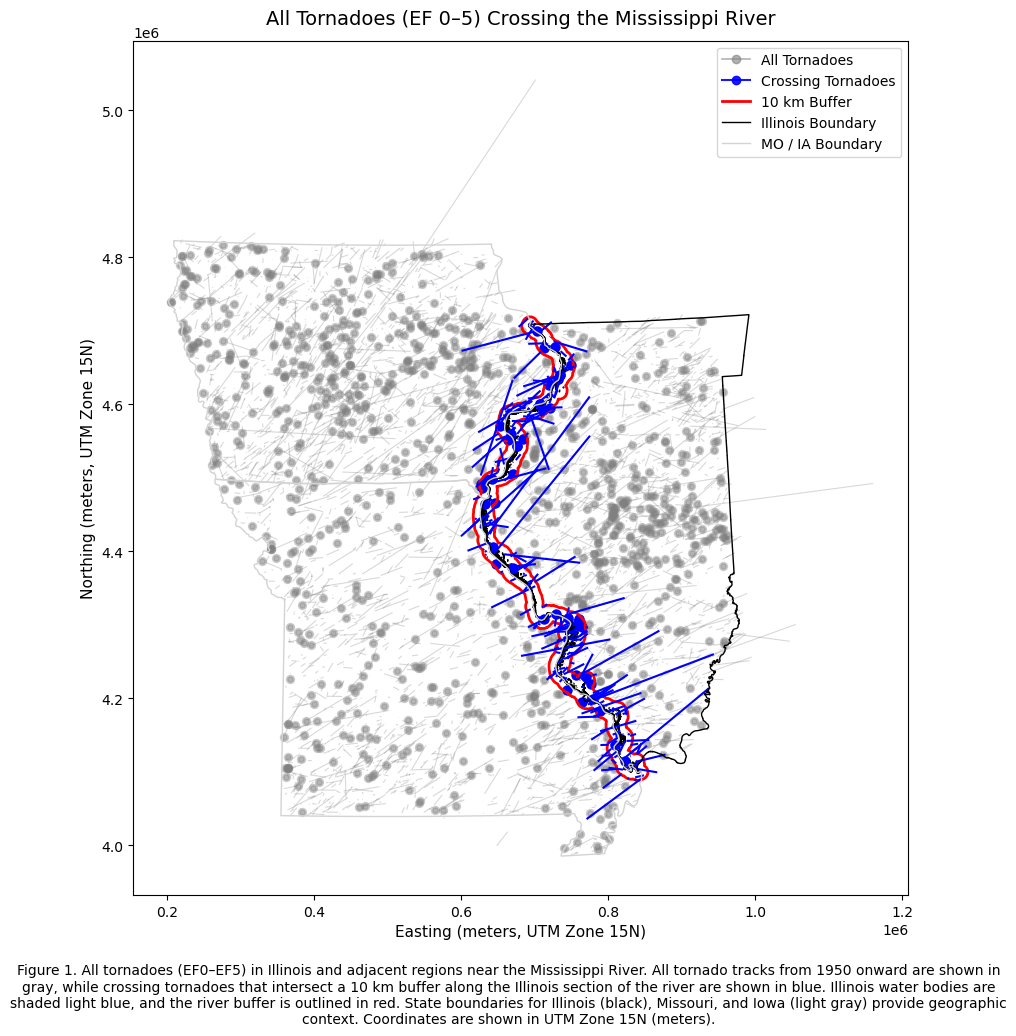

In [68]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Step 5: Plot ---
fig, ax = plt.subplots(figsize=(10, 14))

# Plot Illinois water and river buffer
water_il.plot(ax=ax, color='lightblue', edgecolor='k')
gpd.GeoSeries([river_buffer]).boundary.plot(ax=ax, color='red', linewidth=2, label='10 km Buffer')

# Plot all tornadoes (lines + points)
tornado_gdf.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.3)
tornado_gdf[tornado_gdf.geometry.geom_type == 'Point'].plot(ax=ax, color='gray', markersize=15, alpha=0.4)

# Plot crossing tornadoes (lines + points)
crossings.plot(ax=ax, color='blue', linewidth=1.5)
crossings[crossings.geometry.geom_type == 'Point'].plot(ax=ax, color='blue', markersize=25)

# Plot Illinois, Missouri, and Iowa boundaries
illinois.boundary.plot(ax=ax, color='black', linewidth=1, label='Illinois Boundary')

states_path = "/home/njm12/ATMS_596/ne_10m_admin_1_states_provinces.shp"
states = gpd.read_file(states_path).to_crs(target_crs)
states_mo_ia = states[states['name'].isin(['Missouri', 'Iowa'])]
states_mo_ia.boundary.plot(ax=ax, color='lightgray', linewidth=1, label='MO / IA Boundary')

# --- Custom legend handles (combined line + point) ---
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=1.2, marker='o', markersize=6, 
           label='All Tornadoes', alpha=0.6),
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o', markersize=6, 
           label='Crossing Tornadoes', alpha=0.9),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary'),
    Line2D([0], [0], color='lightgray', linewidth=1, label='MO / IA Boundary'),
]

# --- Labels, title, and caption ---
ax.legend(handles=legend_elements, loc='upper right')
ax.set_title("All Tornadoes (EF 0–5) Crossing the Mississippi River", fontsize=14, pad=12)
ax.set_xlabel("Easting (meters, UTM Zone 15N)", fontsize=11)
ax.set_ylabel("Northing (meters, UTM Zone 15N)", fontsize=11)

# Figure caption
caption = (
    "Figure 1. All tornadoes (EF0–EF5) in Illinois and adjacent regions near the Mississippi River. "
    "All tornado tracks from 1950 onward are shown in gray, while crossing tornadoes that intersect a 10 km buffer "
    "along the Illinois section of the river are shown in blue. Illinois water bodies are shaded light blue, "
    "and the river buffer is outlined in red. State boundaries for Illinois (black), Missouri, and Iowa (light gray) "
    "provide geographic context. Coordinates are shown in UTM Zone 15N (meters)."
)
plt.figtext(0.5, 0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)

plt.show()

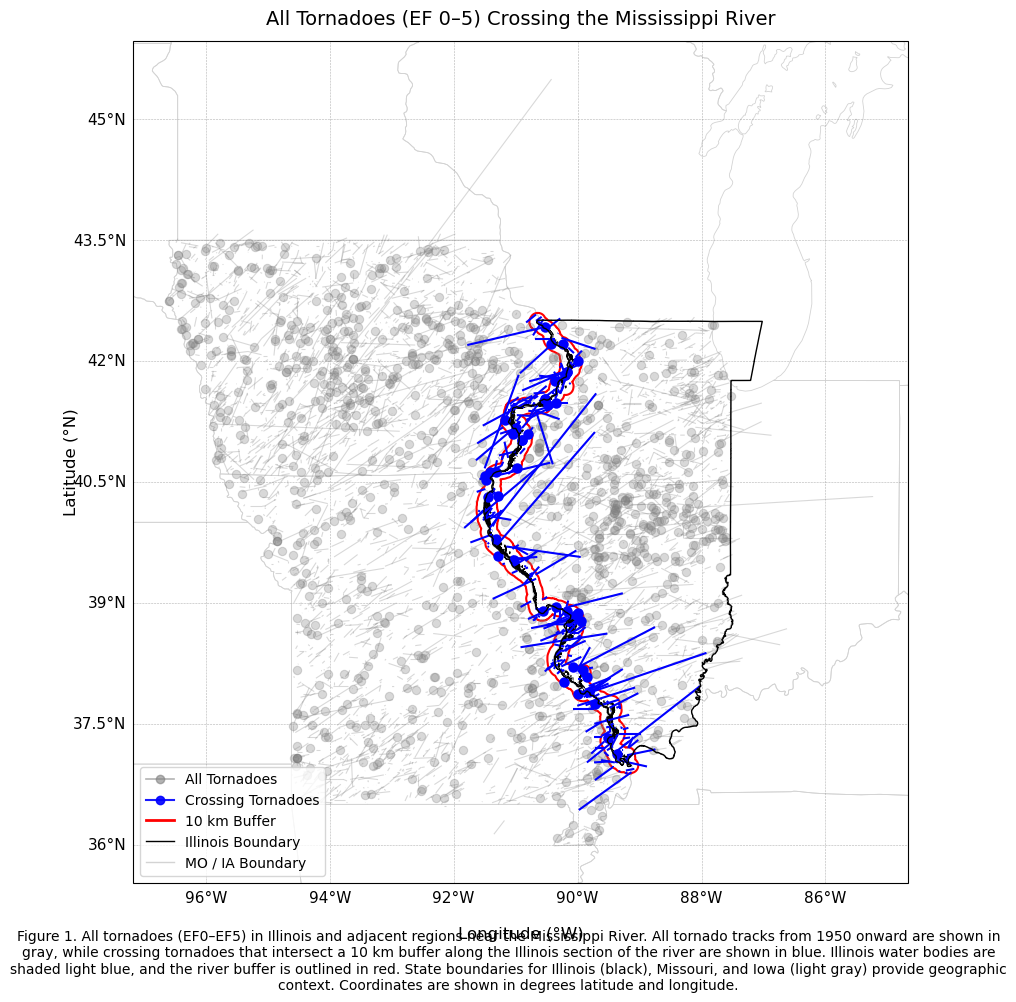

In [69]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Reproject all layers to geographic (EPSG:4326)
tornado_geo = tornado_gdf.to_crs("EPSG:4326")
crossings_geo = crossings.to_crs("EPSG:4326")
water_il_geo = water_il.to_crs("EPSG:4326")
illinois_geo = illinois.to_crs("EPSG:4326")
river_buffer_geo = gpd.GeoSeries([river_buffer], crs=water_il.crs).to_crs("EPSG:4326")

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map background
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='lightgray', linewidth=0.6)

# Plot layers
water_il_geo.plot(ax=ax, color='lightblue', edgecolor='k', transform=ccrs.PlateCarree(), zorder=1)
river_buffer_geo.boundary.plot(ax=ax, color='red', linewidth=1.5, transform=ccrs.PlateCarree(), label='10 km Buffer', zorder=2)
tornado_geo.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.3, transform=ccrs.PlateCarree(), label='All Tornadoes', zorder=3)
crossings_geo.plot(ax=ax, color='blue', linewidth=1.5, transform=ccrs.PlateCarree(), label='Crossing Tornadoes', zorder=4)
illinois_geo.boundary.plot(ax=ax, color='black', linewidth=1, transform=ccrs.PlateCarree(), zorder=5)

# Gridlines and coordinate labels
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.6, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 11}
gl.ylabel_style = {'size': 11}

# Add axis labels manually
ax.text(0.5, -0.06, 'Longitude (°W)', va='center', ha='center', fontsize=12, transform=ax.transAxes)
ax.text(-0.08, 0.5, 'Latitude (°N)', va='center', ha='center', rotation='vertical', fontsize=12, transform=ax.transAxes)

# --- Custom legend handles (combined line + point) ---
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=1.2, marker='o', markersize=6, 
           label='All Tornadoes', alpha=0.6),
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o', markersize=6, 
           label='Crossing Tornadoes', alpha=0.9),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary'),
    Line2D([0], [0], color='lightgray', linewidth=1, label='MO / IA Boundary'),
]

# Add title and legend
ax.set_title("All Tornadoes (EF 0–5) Crossing the Mississippi River", fontsize=14, pad=12)
ax.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=True)

# Caption
caption = (
    "Figure 1. All tornadoes (EF0–EF5) in Illinois and adjacent regions near the Mississippi River. "
    "All tornado tracks from 1950 onward are shown in gray, while crossing tornadoes that intersect a 10 km buffer "
    "along the Illinois section of the river are shown in blue. Illinois water bodies are shaded light blue, "
    "and the river buffer is outlined in red. State boundaries for Illinois (black), Missouri, and Iowa (light gray) "
    "provide geographic context. Coordinates are shown in degrees latitude and longitude."
)
plt.figtext(0.5, 0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

In [70]:
# -------------------------------------------------------------------
# --- Identify west-side, east-side, and crossing weak tornadoes ---
# -------------------------------------------------------------------

# 1. Start with all tornadoes only (EF 0–5)
weak_tornadoes = tornado_gdf[tornado_gdf["mag"].isin([0, 1, 2, 3, 4, 5])].copy()

# 2. Tornadoes that cross/touch the river (same as before)
crossing_tornadoes = weak_tornadoes[weak_tornadoes.intersects(river_il_geom)]

# 3. Tornadoes that are within or touch the 10 km buffer but do NOT touch/cross the river
buffer_only = weak_tornadoes[
    weak_tornadoes.intersects(river_buffer) & 
    (~weak_tornadoes.intersects(river_il_geom))
].copy()

# 4. Compute centroid of each tornado track for side determination
buffer_only["centroid"] = buffer_only.geometry.centroid

# 5. Determine whether centroids are west or east of the river
#    We'll use the river's centroid X-coordinate as an approximate divider
river_center_x = river_il_geom.centroid.x

west_side = buffer_only[buffer_only["centroid"].x < river_center_x]
east_side = buffer_only[buffer_only["centroid"].x >= river_center_x]

# 6. Print summary results
print("\n--- Tornado Interaction Summary ---")
print(f"Total tornadoes: {len(weak_tornadoes)}")
print(f"  • West-side (within/touching 10 km buffer, not touching river): {len(west_side)}")
print(f"  • East-side (within/touching 10 km buffer, not touching river): {len(east_side)}")
print(f"  • Crossing/touching the river: {len(crossing_tornadoes)}")
print(f"  • Sum check: {len(west_side) + len(east_side) + len(crossing_tornadoes)} (should equal 372)")


--- Tornado Interaction Summary ---
Total tornadoes: 5793
  • West-side (within/touching 10 km buffer, not touching river): 120
  • East-side (within/touching 10 km buffer, not touching river): 163
  • Crossing/touching the river: 89
  • Sum check: 372 (should equal 372)


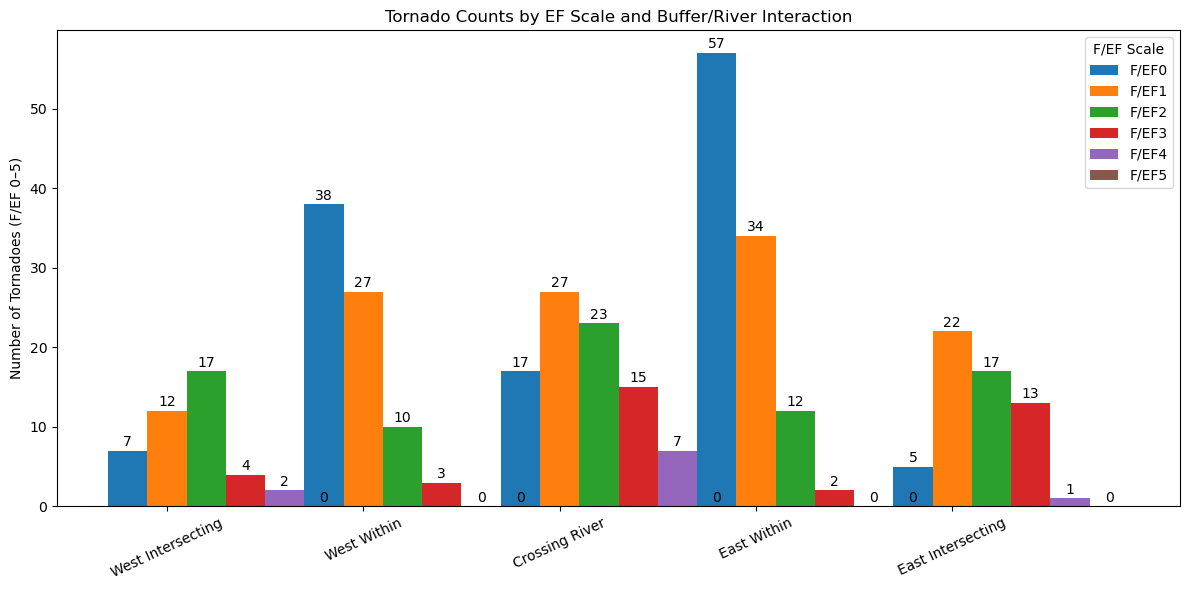

In [71]:
import matplotlib.pyplot as plt

# --- Step 1: Define helper to classify "completely within" vs "intersecting" ---
def completely_within(geom, buffer_geom):
    if geom.geom_type == "Point":
        return buffer_geom.contains(geom)
    elif geom.geom_type == "LineString":
        # Get boundary points as a list
        pts = list(geom.boundary.geoms)
        return buffer_geom.contains(pts[0]) and buffer_geom.contains(pts[1])
    return False

# --- Step 2: Separate the west and east tornadoes into intersecting vs completely within ---
west_intersecting = west_side[~west_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
west_within = west_side[west_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]

east_intersecting = east_side[~east_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
east_within = east_side[east_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]

# crossing already exists
crossing = crossing_tornadoes.copy()

# --- Step 3: Compute EF-scale counts for each bin ---
bins = {
    "West Intersecting": west_intersecting,
    "West Within": west_within,
    "Crossing River": crossing,
    "East Within": east_within,
    "East Intersecting": east_intersecting
}

ef_counts = {k: v['mag'].value_counts().reindex([0,1,2,3,4,5], fill_value=0) for k,v in bins.items()}

# Convert to DataFrame for plotting
ef_df = pd.DataFrame(ef_counts).T  # rows=bins, columns=EF scale
ef_df.index.name = 'Bin'
ef_df.columns = ['F/EF0', 'F/EF1', 'F/EF2', 'F/EF3', 'F/EF4', 'F/EF5']

# --- Step 4: Plot clustered bar chart ---
fig, ax = plt.subplots(figsize=(12,6))

bar_width = 0.2
x = np.arange(len(ef_df))  # 5 clusters

# Store bar containers for labeling
bars = []
for i, ef in enumerate(ef_df.columns):
    b = ax.bar(x + i*bar_width, ef_df[ef], width=bar_width, label=ef)
    bars.append(b)

# --- Add data labels on top of bars ---
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,  # center of the bar
            height + 0.2,                     # slightly above the bar
            f'{int(height)}',                 # convert to integer if counts
            ha='center', va='bottom', fontsize=10
        )

ax.set_xticks(x + bar_width)
ax.set_xticklabels(ef_df.index, rotation=25)
ax.set_ylabel("Number of Tornadoes (F/EF 0–5)")
ax.set_title("Tornado Counts by EF Scale and Buffer/River Interaction")
ax.legend(title="F/EF Scale")
plt.tight_layout()
plt.show()

Total tornadoes in plot: 372


/tmp/ipykernel_105/725604867.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




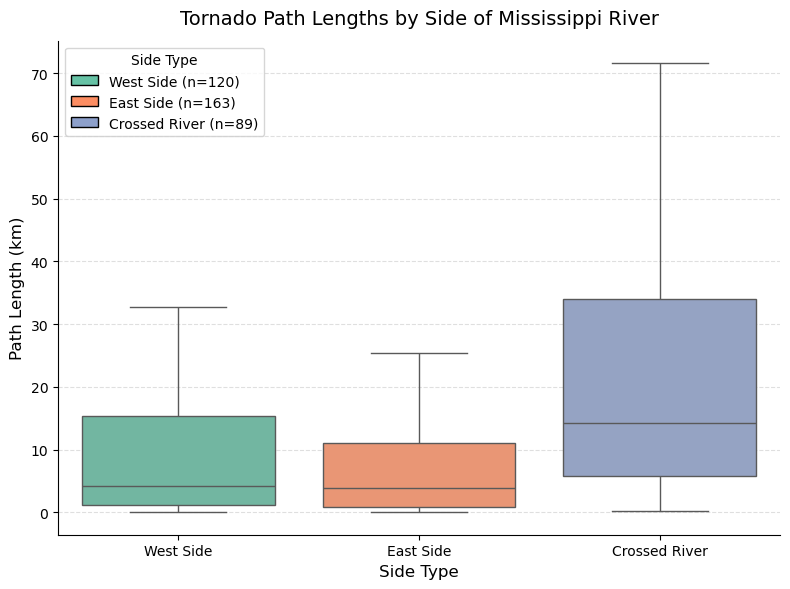

Total tornadoes in path length plot: 372

Five-number summary for tornado path lengths (km):
                    Min        Q1     Median         Q3         Max
side_type                                                          
Crossed River  0.160934  5.857998  14.162192  33.957074  237.216716
East Side      0.032187  0.804670   3.878509  11.015932  122.148906
West Side      0.000000  1.118491   4.200377  15.365174  147.254610


In [72]:
# --- Step 1: Combine intersecting + within for each side ---
west_side_plot = pd.concat([west_intersecting, west_within], ignore_index=True)
east_side_plot = pd.concat([east_intersecting, east_within], ignore_index=True)
cross_plot = crossing.copy()  # already exists

# Keep only path length and label each category
west_side_plot = west_side_plot[['len']].copy()
west_side_plot['side_type'] = "West Side"

east_side_plot = east_side_plot[['len']].copy()
east_side_plot['side_type'] = "East Side"

cross_plot = cross_plot[['len']].copy()
cross_plot['side_type'] = "Crossed River"

# --- Step 2: Convert path lengths to kilometers ---
for df in [west_side_plot, east_side_plot, cross_plot]:
    df['len'] = df['len'] * 1.60934  # miles → km

# --- Step 3: Combine for plotting ---
plot_df = pd.concat([west_side_plot, east_side_plot, cross_plot], ignore_index=True)
print("Total tornadoes in plot:", len(plot_df))  # Should be 372

# --- Step 4: Create boxplot ---
plt.figure(figsize=(8, 6))
palette = sns.color_palette("Set2", 3)

ax = sns.boxplot(
    data=plot_df,
    x="side_type",
    y="len",
    palette=palette,
    showfliers=False
)

# --- Step 5: Build color-coded legend with counts ---
counts = plot_df["side_type"].value_counts()
legend_elements = [
    Patch(facecolor=palette[i], edgecolor='black',
          label=f"{cat} (n={counts[cat]})")
    for i, cat in enumerate(['West Side', 'East Side', 'Crossed River'])
]

ax.legend(
    handles=legend_elements,
    loc='upper left',
    fontsize=10,
    title="Side Type",
    frameon=True
)

# --- Step 6: Final formatting ---
ax.set_title("Tornado Path Lengths by Side of Mississippi River", fontsize=14, pad=12)
ax.set_xlabel("Side Type", fontsize=12)
ax.set_ylabel("Path Length (km)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

# Compute five-number summary for each category
summary_stats = plot_df.groupby("side_type")['len'].describe(percentiles=[0.25, 0.5, 0.75])[['min', '25%', '50%', '75%', 'max']]

# Rename columns for clarity
summary_stats.columns = ['Min', 'Q1', 'Median', 'Q3', 'Max']

# Display
print("Total tornadoes in path length plot:", len(plot_df))  # Should be 246
print("\nFive-number summary for tornado path lengths (km):")
print(summary_stats)

In [73]:
# --- Prepare data ---
groups = plot_df.groupby('side_type')['len'].apply(list)

# Extract group data
west_len = groups['West Side']
east_len = groups['East Side']
cross_len = groups['Crossed River']

# --- 1. Overall Kruskal-Wallis test ---
stat, p = kruskal(west_len, east_len, cross_len)
print(f"Overall Kruskal-Wallis test: H = {stat:.3f}, p = {p:.4f}")

# --- 2. Pairwise comparisons ---
pairs = list(itertools.combinations(groups.index, 2))
results = []
for a, b in pairs:
    stat, p = kruskal(groups[a], groups[b])
    results.append({'Group1': a, 'Group2': b, 'H': stat, 'p-value': p})

# Convert to DataFrame for readability
pairwise_df = pd.DataFrame(results)
print("\nPairwise Kruskal-Wallis results:")
print(pairwise_df)

#Evaluated at the 0.05 significance level.

Overall Kruskal-Wallis test: H = 41.970, p = 0.0000

Pairwise Kruskal-Wallis results:
          Group1     Group2          H       p-value
0  Crossed River  East Side  38.999485  4.239175e-10
1  Crossed River  West Side  27.384670  1.667479e-07
2      East Side  West Side   0.159294  6.898077e-01


### Kruskal-Wallis Test on Tornado Path Lengths for All Tornadoes (EF0–EF5) by Side of Mississippi River

**Overall Test:**
- Kruskal-Wallis H = 41.970 , p < 0.0001  
- Interpretation: There is a statistically significant difference in tornado path lengths among the three groups (West Side, East Side, Crossed River).

**Pairwise Comparisons:**

| Group 1       | Group 2    | H        | p-value        | Significant? |
|---------------|------------|----------|----------------|--------------|
| Crossed River | East Side  | 38.999   | 4.24 × 10⁻¹⁰   | Yes          |
| Crossed River | West Side  | 27.385   | 1.67 × 10⁻⁷    | Yes          |
| East Side     | West Side  | 0.159    | 0.689808       | No           |

**Summary:**
- Tornadoes that **cross the river** have **significantly different path lengths** compared to tornadoes on either side of the river.
- Tornadoes **on the west and east sides** of the river **do not differ significantly** from each other in path length..in path length.

/tmp/ipykernel_105/2638795809.py:22: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




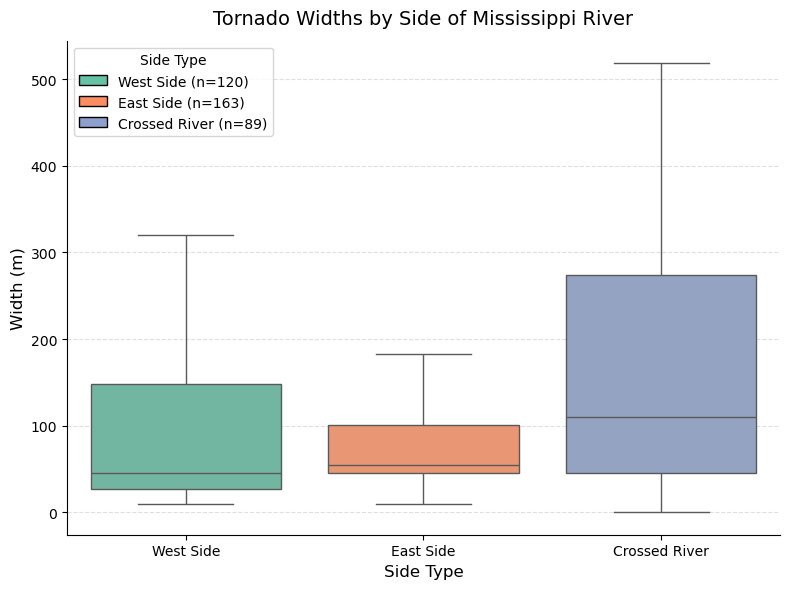

Total tornadoes in width plot: 372

Five-number summary for tornado widths (m):
                  min     25%      50%      75%       max
side_type                                               
Crossed River  0.000  45.720  109.728  274.320  2011.680
East Side      9.144  45.720   54.864  100.584  1609.344
West Side      9.144  27.432   45.720  148.590   914.400


In [74]:
# --- Step 1: Prepare categories ---
categories = {
    'West Side': pd.concat([west_intersecting, west_within], ignore_index=True),
    'East Side': pd.concat([east_intersecting, east_within], ignore_index=True),
    'Crossed River': crossing.copy()
}

# --- Step 2: Map widths (yards -> meters) and side_type ---
dfs = []
for cat, df in categories.items():
    temp = df[['wid']].copy()
    temp['width_m'] = temp['wid'] * 0.9144  # convert yards -> meters
    temp['side_type'] = cat
    dfs.append(temp[['width_m','side_type']])

width_plot_df = pd.concat(dfs, ignore_index=True)

# --- Step 3: Boxplot ---
plt.figure(figsize=(8,6))
palette = sns.color_palette("Set2", 3)

ax = sns.boxplot(
    data=width_plot_df,
    x='side_type',
    y='width_m',
    palette=palette,
    showfliers=False
)

# --- Step 4: Add legend with counts ---
counts = width_plot_df['side_type'].value_counts()
legend_elements = [
    Patch(facecolor=palette[i], edgecolor='black',
          label=f"{cat} (n={counts[cat]})")
    for i, cat in enumerate(['West Side', 'East Side', 'Crossed River'])
]
ax.legend(
    handles=legend_elements,
    loc='upper left',
    fontsize=10,
    title="Side Type",
    frameon=True
)

# --- Step 5: Formatting ---
ax.set_title("Tornado Widths by Side of Mississippi River", fontsize=14, pad=12)
ax.set_xlabel("Side Type", fontsize=12)
ax.set_ylabel("Width (m)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

print("Total tornadoes in width plot:", len(width_plot_df))

# --- Step 6: Compute five-number summary statistics ---
width_summary = width_plot_df.groupby('side_type')['width_m'].describe(percentiles=[0.25,0.5,0.75])[['min','25%','50%','75%','max']]
print("\nFive-number summary for tornado widths (m):\n", width_summary)

In [75]:
# Extract the groups
west_width = width_plot_df[width_plot_df['side_type'] == 'West Side']['width_m']
east_width = width_plot_df[width_plot_df['side_type'] == 'East Side']['width_m']
cross_width = width_plot_df[width_plot_df['side_type'] == 'Crossed River']['width_m']

# Overall Kruskal-Wallis test
H_overall, p_overall = kruskal(west_width, east_width, cross_width)
print(f"Overall Kruskal-Wallis test: H = {H_overall:.3f}, p = {p_overall:.4f}")

# Pairwise comparisons
groups = {'West Side': west_width, 'East Side': east_width, 'Crossed River': cross_width}
pairs = list(itertools.combinations(groups.keys(), 2))

pairwise_results = []
for g1, g2 in pairs:
    H, p = kruskal(groups[g1], groups[g2])
    pairwise_results.append({
        'Group1': g1,
        'Group2': g2,
        'H': H,
        'p-value': p
    })

pairwise_df = pd.DataFrame(pairwise_results)
print("\nPairwise Kruskal-Wallis results:")
print(pairwise_df)

#Evaluated at the 0.05 significance level.

Overall Kruskal-Wallis test: H = 18.973, p = 0.0001

Pairwise Kruskal-Wallis results:
      Group1         Group2          H   p-value
0  West Side      East Side   1.486631  0.222740
1  West Side  Crossed River  14.019422  0.000181
2  East Side  Crossed River  14.988780  0.000108


### Kruskal-Wallis Test on Tornado Widths for All Tornadoes (EF0–EF5) by Side of Mississippi River

**Overall Test:**
- Kruskal-Wallis H = 18.973 , p = 0.0001  
- Interpretation: There is a statistically significant difference in tornado widths among the three groups (West Side, East Side, Crossed River).

**Pairwise Comparisons:**

| Group 1       | Group 2       | H        | p-value        | Significant? |
|---------------|---------------|----------|----------------|--------------|
| West Side     | East Side     | 1.487    | 0.222740       | No           |
| West Side     | Crossed River | 14.019   | 0.000181       | Yes          |
| East Side     | Crossed River | 14.989   | 0.000108       | Yes          |

**Summary:**
- Tornado widths differ significantly between **Crossed River** tornadoes and tornadoes on either side of the river.
- Tornado widths **on the West and East sides** of the river **do not differ significantly** from each other.each other.ver.

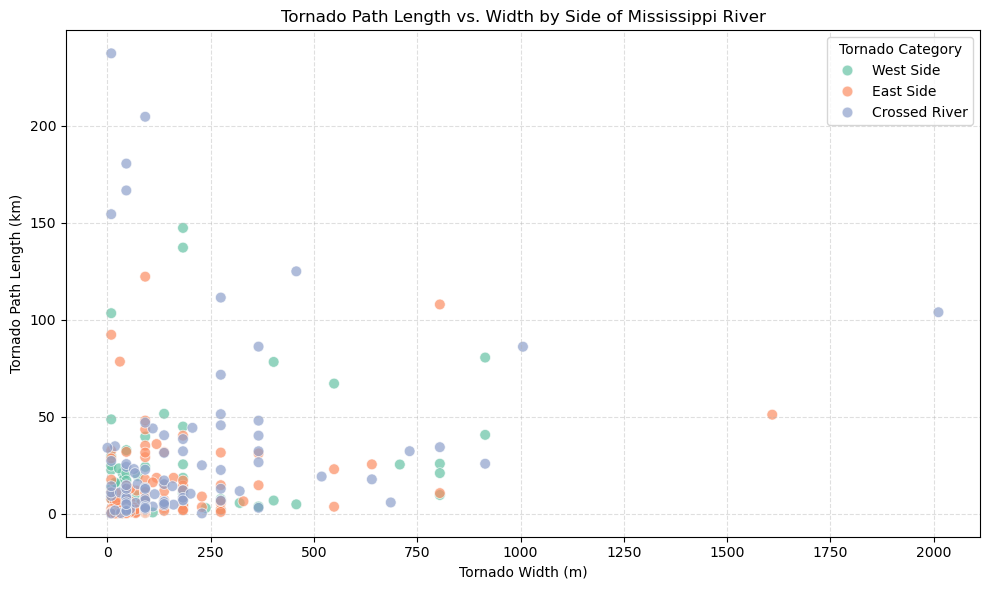

In [76]:
# --- Step 1: Combine pathlengths and widths into a single DataFrame ---
scatter_df = plot_df[['len','side_type']].copy()
scatter_df = scatter_df.rename(columns={'len':'len_km'})

# Add widths from width_plot_df using same index
scatter_df['width_m'] = width_plot_df['width_m']

# --- Step 2: Scatter plot ---
plt.figure(figsize=(10,6))
palette = sns.color_palette("Set2", 3)

sns.scatterplot(
    data=scatter_df,
    x='width_m',
    y='len_km',
    hue='side_type',
    palette=palette,
    s=60,
    alpha=0.7
)

plt.xlabel("Tornado Width (m)")
plt.ylabel("Tornado Path Length (km)")
plt.title("Tornado Path Length vs. Width by Side of Mississippi River")
plt.legend(title="Tornado Category")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [77]:
# --- Prepare DataFrame ---
scatter_df = plot_df[['len','side_type']].copy()
scatter_df = scatter_df.rename(columns={'len':'len_km'})
scatter_df['width_m'] = width_plot_df['width_m']

# --- Interactive scatterplot ---
fig = px.scatter(
    scatter_df,
    x='width_m',
    y='len_km',
    color='side_type',
    labels={
        'width_m': 'Tornado Width (m)',
        'len_km': 'Tornado Path Length (km)',
        'side_type': 'Tornado Category'
    },
    hover_data=['width_m', 'len_km', 'side_type'],
    title="Tornado Path Length vs. Width by Side of Mississippi River",
    width=900,
    height=600
)

# Optionally, add a rectangle to indicate the 0-150 km x 0-1000 m region
fig.add_shape(
    type="rect",
    x0=0, y0=0,
    x1=1000, y1=150,
    line=dict(color="red", width=2),
    fillcolor="rgba(0,0,0,0)"  # transparent fill
)

fig.show()

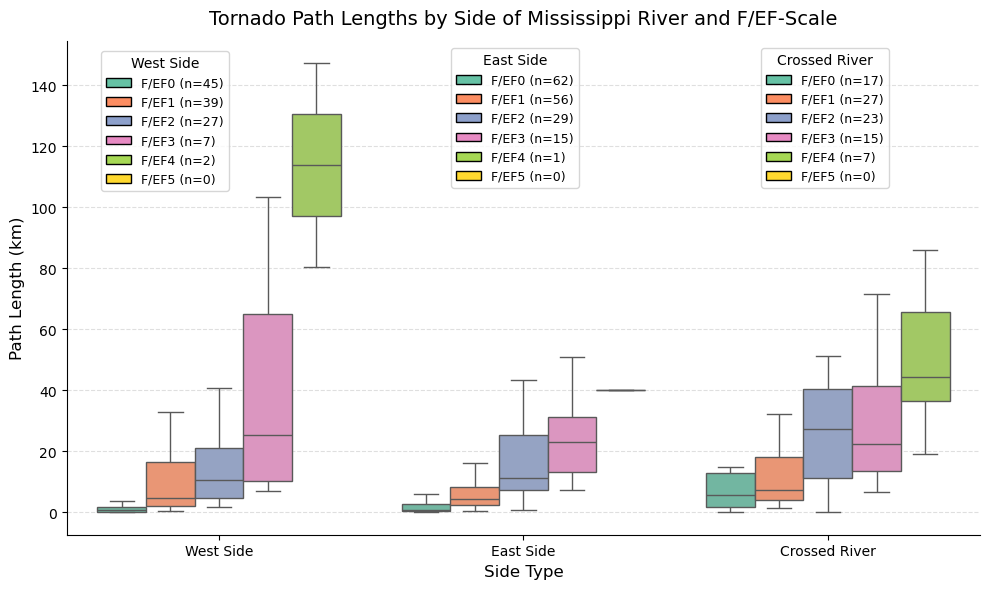

In [48]:
# --- Step 0: Prepare DataFrames for each tornado category ---
west_side_plot = pd.concat([west_intersecting, west_within], ignore_index=True)
east_side_plot = pd.concat([east_intersecting, east_within], ignore_index=True)
cross_plot = crossing.copy()

for df, name in zip([west_side_plot, east_side_plot, cross_plot],
                    ["West Side","East Side","Crossed River"]):
    df['side_type'] = name
    df['len'] = df['len'] * 1.60934  # miles -> km

west_side_plot = west_side_plot[['len','mag','side_type']]
east_side_plot = east_side_plot[['len','mag','side_type']]
cross_plot = cross_plot[['len','mag','side_type']]

plot_df = pd.concat([west_side_plot, east_side_plot, cross_plot], ignore_index=True)

# --- Step 1: Set palette for EF-scale ---
ef_palette = {0: "#66c2a5",1: "#fc8d62",2: "#8da0cb",3: "#e78ac3",4: "#a6d854",5: "#ffd92f"}  # EF0,1,2,3,4,5

# --- Step 2: Plot boxplot ---
plt.figure(figsize=(10,6))
ax = sns.boxplot(
    data=plot_df,
    x="side_type",
    y="len",
    hue="mag",
    palette=ef_palette,
    showfliers=False
)

ax.legend_.remove()

ax.set_title("Tornado Path Lengths by Side of Mississippi River and F/EF-Scale", fontsize=14, pad=12)
ax.set_xlabel("Side Type", fontsize=12)
ax.set_ylabel("Path Length (km)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()

# --- Step 3: Build all three legends manually using fig.legend ---
fig = plt.gcf()
legend_elements = []

# For each cluster, create legend elements with counts
clusters = ['West Side','East Side','Crossed River']
positions = [(0.10, 0.915),(0.45, 0.92),(0.76, 0.92)]  # relative to figure

for cluster, pos in zip(clusters, positions):
    cluster_df = plot_df[plot_df['side_type'] == cluster]
    counts = cluster_df['mag'].value_counts().reindex([0,1,2,3,4,5], fill_value=0)
    cluster_legend = [Patch(facecolor=ef_palette[ef], edgecolor='black',
                            label=f"F/EF{ef} (n={counts[ef]})") for ef in [0,1,2,3,4,5]]
    fig.legend(handles=cluster_legend, title=cluster, loc='upper left', bbox_to_anchor=pos, fontsize=9, frameon=True)

plt.tight_layout()
plt.show()

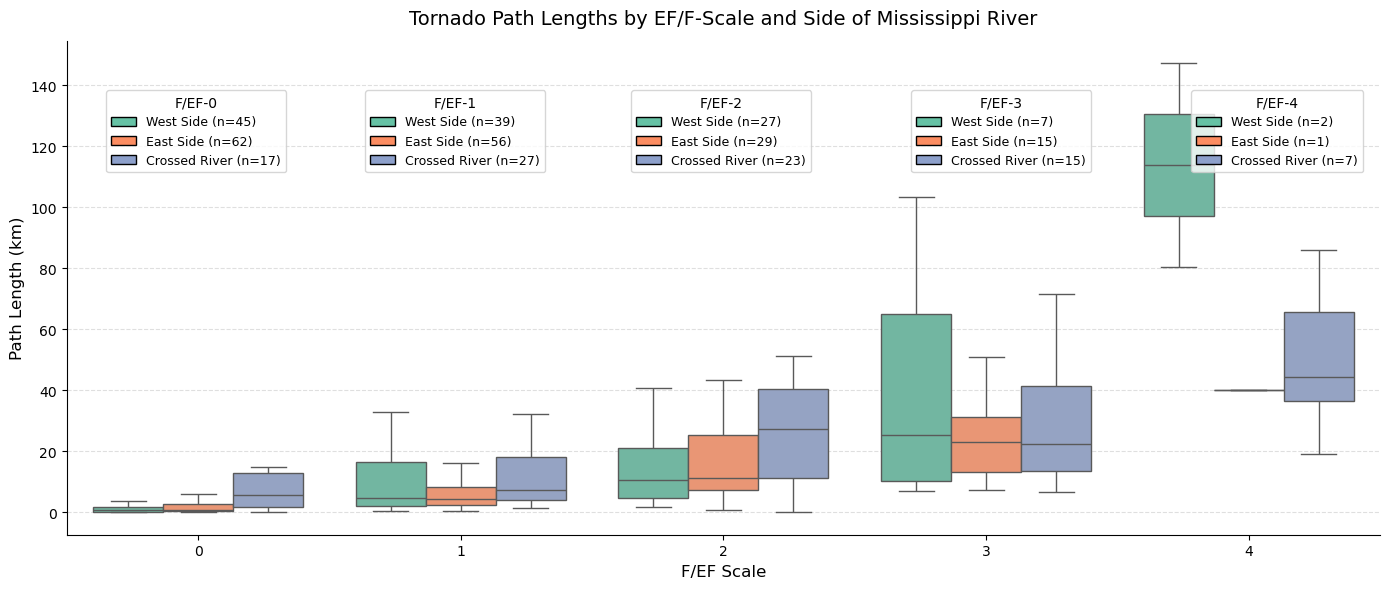

In [45]:
# --- Step 0: Prepare DataFrames ---
west_side_plot = pd.concat([west_intersecting, west_within], ignore_index=True)
east_side_plot = pd.concat([east_intersecting, east_within], ignore_index=True)
cross_plot = crossing.copy()

# --- Step 0: Prepare DataFrames ---
west_side_plot = pd.concat([west_intersecting, west_within], ignore_index=True)
east_side_plot = pd.concat([east_intersecting, east_within], ignore_index=True)
cross_plot = crossing.copy()

for df, name in zip([west_side_plot, east_side_plot, cross_plot],
                    ["West Side","East Side","Crossed River"]):
    df['side_type'] = name
    df['len'] = df['len'] * 1.60934  # miles -> km

west_side_plot = west_side_plot[['len','mag','side_type']]
east_side_plot = east_side_plot[['len','mag','side_type']]
cross_plot = cross_plot[['len','mag','side_type']]

plot_df = pd.concat([west_side_plot, east_side_plot, cross_plot], ignore_index=True)

# --- Step 1: Set palette for tornado categories ---
category_palette = {"West Side":"#66c2a5",
                    "East Side":"#fc8d62",
                    "Crossed River":"#8da0cb"}

# --- Step 2: Plot clustered boxplots ---
plt.figure(figsize=(14,6))
ax = sns.boxplot(
    data=plot_df,
    x="mag",                 # EF-scale on x-axis
    y="len",                 # Path length
    hue="side_type",         # Separate color per side
    palette=category_palette,
    showfliers=False
)

ax.legend_.remove()

ax.set_title("Tornado Path Lengths by EF/F-Scale and Side of Mississippi River", fontsize=14, pad=12)
ax.set_xlabel("F/EF Scale", fontsize=12)
ax.set_ylabel("Path Length (km)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()

# --- Step 3: Add 3 legends, one per EF-scale ---
fig = plt.gcf()
ef_scales = [0,1,2,3,4,5]
legend_positions = [(0.075, 0.85),(0.26, 0.85),(0.45, 0.85),(0.65, 0.85),(0.85, 0.85)]  # top-left, top-center, top-right

for ef, pos in zip(ef_scales, legend_positions):
    # Extract counts for each side for this EF
    counts = {side: plot_df[(plot_df['side_type']==side) & (plot_df['mag']==ef)]['len'].count()
              for side in ['West Side','East Side','Crossed River']}
    
    legend_patches = [
        Patch(facecolor=category_palette[side], edgecolor='black',
              label=f"{side} (n={counts[side]})")
        for side in ['West Side','East Side','Crossed River']
    ]
    
    fig.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=pos,
               fontsize=9, frameon=True, title=f"F/EF-{ef}")

plt.tight_layout()
plt.show()

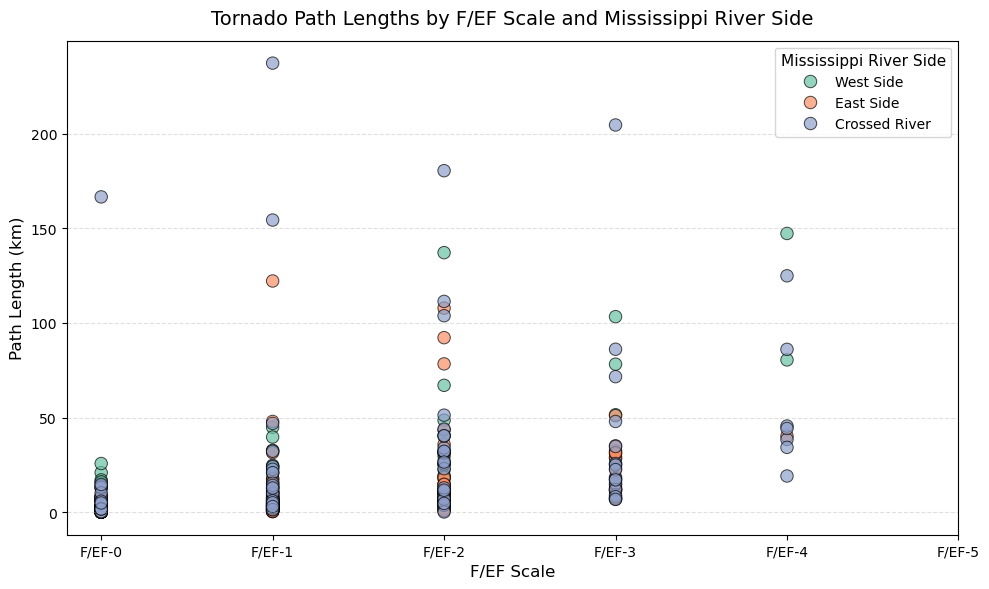

In [32]:
# --- Step 1: Set color palette for sides ---
palette = {"West Side": "#66c2a5",
           "East Side": "#fc8d62",
           "Crossed River": "#8da0cb"}

# --- Step 2: Create scatter plot ---
plt.figure(figsize=(10,6))
ax = sns.scatterplot(
    data=plot_df,
    x='mag',          # F/EF scale
    y='len',          # Path length in km
    hue='side_type',  # Side of Mississippi
    palette=palette,
    s=80,             # Marker size
    alpha=0.7,
    edgecolor='k'
)

# --- Step 3: Formatting ---
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['F/EF-0','F/EF-1','F/EF-2','F/EF-3','F/EF-4','F/EF-5'])
ax.set_xlabel("F/EF Scale", fontsize=12)
ax.set_ylabel("Path Length (km)", fontsize=12)
ax.set_title("Tornado Path Lengths by F/EF Scale and Mississippi River Side", fontsize=14, pad=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# --- Step 4: Legend ---
ax.legend(title="Mississippi River Side", fontsize=10, title_fontsize=11, frameon=True)

plt.tight_layout()
plt.show()

#Note for this plot: Still has outliers, which makes it hard to visualize and point size doesn't change based on side type. 

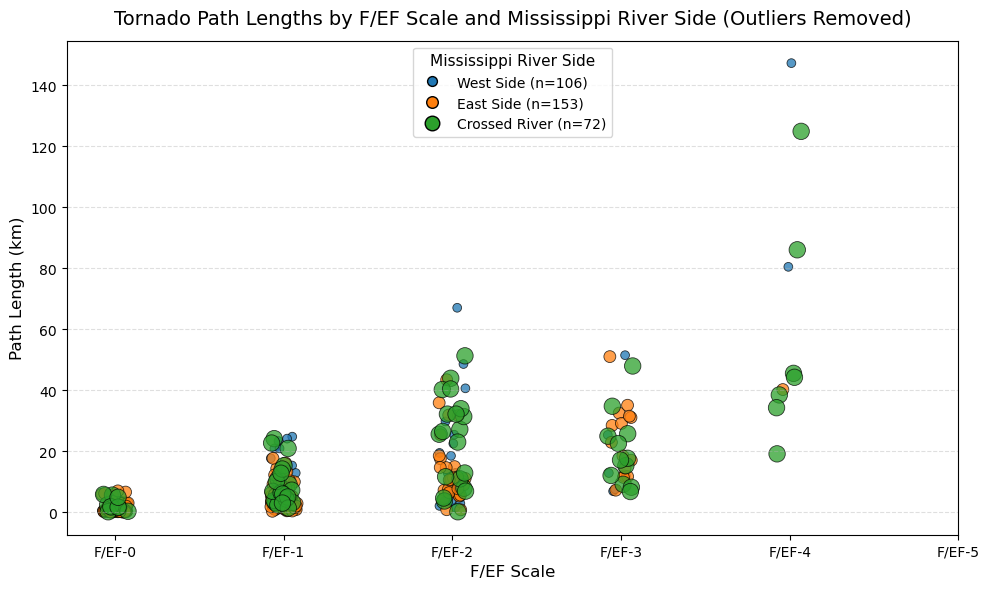

In [34]:
# --- Step 1: Compute outlier thresholds by EF-scale ---
thresholds = {}
filtered_dfs = []

for ef, group in plot_df.groupby('mag'):
    q1 = group['len'].quantile(0.25)
    q3 = group['len'].quantile(0.75)
    iqr = q3 - q1
    upper = q3 + 1.5 * iqr  # standard IQR rule
    thresholds[ef] = upper
    
    # Filter out outliers above threshold
    filtered = group[group['len'] <= upper]
    filtered_dfs.append(filtered)

# Combine filtered data
filtered_plot_df = pd.concat(filtered_dfs, ignore_index=True)

# --- Print thresholds for transparency ---
#print("Outlier thresholds by EF-scale (km):")
#for ef, thr in thresholds.items():
#    print(f"EF-{ef}: {thr:.2f} km")

# --- Step 2: Scatter plot setup ---
palette = {
    "West Side": "#1f77b4",     # Bold blue
    "East Side": "#ff7f0e",     # Vivid orange
    "Crossed River": "#2ca02c"  # Strong green
}

# Assign sizes by category
size_map = {
    "West Side": 50,
    "East Side": 70,
    "Crossed River": 110
}
filtered_plot_df["point_size"] = filtered_plot_df["side_type"].map(size_map)

# Add horizontal jitter to EF-scale for visibility
jitter_strength = 0.08
filtered_plot_df["mag_jitter"] = filtered_plot_df["mag"] + np.random.uniform(
    -jitter_strength, jitter_strength, size=len(filtered_plot_df)
)

# --- Step 3: Scatter plot ---
plt.figure(figsize=(10,6))
ax = sns.scatterplot(
    data=filtered_plot_df,
    x='mag_jitter',
    y='len',
    hue='side_type',
    size='point_size',
    sizes=(40, 140),
    palette=palette,
    alpha=0.75,
    edgecolor='black',
    linewidth=0.6,
    legend=False  # We'll make a custom legend
)

# --- Step 4: Custom unified legend with size + color ---
legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f"West Side (n={sum(filtered_plot_df['side_type']=='West Side')})",
        markerfacecolor=palette['West Side'],
        markersize=np.sqrt(size_map['West Side']),  # scale size visually
        markeredgecolor='black'
    ),
    Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f"East Side (n={sum(filtered_plot_df['side_type']=='East Side')})",
        markerfacecolor=palette['East Side'],
        markersize=np.sqrt(size_map['East Side']),
        markeredgecolor='black'
    ),
    Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f"Crossed River (n={sum(filtered_plot_df['side_type']=='Crossed River')})",
        markerfacecolor=palette['Crossed River'],
        markersize=np.sqrt(size_map['Crossed River']),
        markeredgecolor='black'
    )
]

ax.legend(
    handles=legend_elements,
    title="Mississippi River Side",
    fontsize=10,
    title_fontsize=11,
    loc='upper center',
    frameon=True
)

# --- Step 5: Formatting ---
ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['F/EF-0', 'F/EF-1','F/EF-2','F/EF-3','F/EF-4','F/EF-5'])
ax.set_xlabel("F/EF Scale", fontsize=12)
ax.set_ylabel("Path Length (km)", fontsize=12)
ax.set_title(
    "Tornado Path Lengths by F/EF Scale and Mississippi River Side (Outliers Removed)",
    fontsize=14, pad=12
)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [35]:
"""
-----------------------------------------------------------------------
Outlier Removal Summary: Tornado Path Lengths
-----------------------------------------------------------------------
This step removes path length outliers using Tukey’s IQR rule,
applied separately for each F/EF-scale (0, 1, 2, 3, 4, 5).

For each EF-scale category:
  1. Compute 25th (Q1) and 75th (Q3) percentiles of path length (km)
  2. Compute IQR = Q3 - Q1
  3. Define upper threshold = Q3 + 1.5 * IQR
  4. Remove tornadoes with path length > upper threshold

Only upper outliers are removed (extremely long tracks),
since very short paths are valid physically.

The filtering is done *per EF-scale* to avoid penalizing stronger
tornadoes that are naturally longer-lived.
-----------------------------------------------------------------------
"""

'\n-----------------------------------------------------------------------\nOutlier Removal Summary: Tornado Path Lengths\n-----------------------------------------------------------------------\nThis step removes path length outliers using Tukey’s IQR rule,\napplied separately for each F/EF-scale (0, 1, 2, 3, 4, 5).\n\nFor each EF-scale category:\n  1. Compute 25th (Q1) and 75th (Q3) percentiles of path length (km)\n  2. Compute IQR = Q3 - Q1\n  3. Define upper threshold = Q3 + 1.5 * IQR\n  4. Remove tornadoes with path length > upper threshold\n\nOnly upper outliers are removed (extremely long tracks),\nsince very short paths are valid physically.\n\nThe filtering is done *per EF-scale* to avoid penalizing stronger\ntornadoes that are naturally longer-lived.\n-----------------------------------------------------------------------\n'

In [36]:
# --- Overall counts ---
original_count = len(plot_df)
filtered_count = len(filtered_plot_df)
removed_count = original_count - filtered_count

print("----------------------------------------------------")
print("Outlier Removal Summary")
print("----------------------------------------------------")
print(f"Original total weak tornadoes:  {original_count}")
print(f"Remaining after filtering:      {filtered_count}")
print(f"Outliers removed:               {removed_count}")
print()

# --- By EF-scale ---
ef_counts_original = plot_df['mag'].value_counts().sort_index()
ef_counts_filtered = filtered_plot_df['mag'].value_counts().sort_index()
ef_removed = ef_counts_original - ef_counts_filtered

print("By EF-scale:")
print(pd.DataFrame({
    'Original': ef_counts_original,
    'Remaining': ef_counts_filtered,
    'Removed': ef_removed
}))
print("----------------------------------------------------")

# --- By side type ---
side_counts_original = plot_df['side_type'].value_counts()
side_counts_filtered = filtered_plot_df['side_type'].value_counts()
side_removed = side_counts_original - side_counts_filtered

print("By side type:")
print(pd.DataFrame({
    'Original': side_counts_original,
    'Remaining': side_counts_filtered,
    'Removed': side_removed
}))
print("----------------------------------------------------")

# --- Optional: upper threshold per EF-scale ---
print("\nUpper threshold (km) per EF-scale:")
for ef, upper in thresholds.items():
    print(f"  EF{ef}: {upper:.2f} km")

----------------------------------------------------
Outlier Removal Summary
----------------------------------------------------
Original total weak tornadoes:  372
Remaining after filtering:      331
Outliers removed:               41

By EF-scale:
     Original  Remaining  Removed
mag                              
0         124        106       18
1         122        111       11
2          79         72        7
3          37         32        5
4          10         10        0
----------------------------------------------------
By side type:
               Original  Remaining  Removed
side_type                                  
East Side           163        153       10
West Side           120        106       14
Crossed River        89         72       17
----------------------------------------------------

Upper threshold (km) per EF-scale:
  EF0: 7.67 km
  EF1: 25.96 km
  EF2: 69.54 km
  EF3: 68.80 km
  EF4: 153.28 km


/tmp/ipykernel_105/1278305356.py:13: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




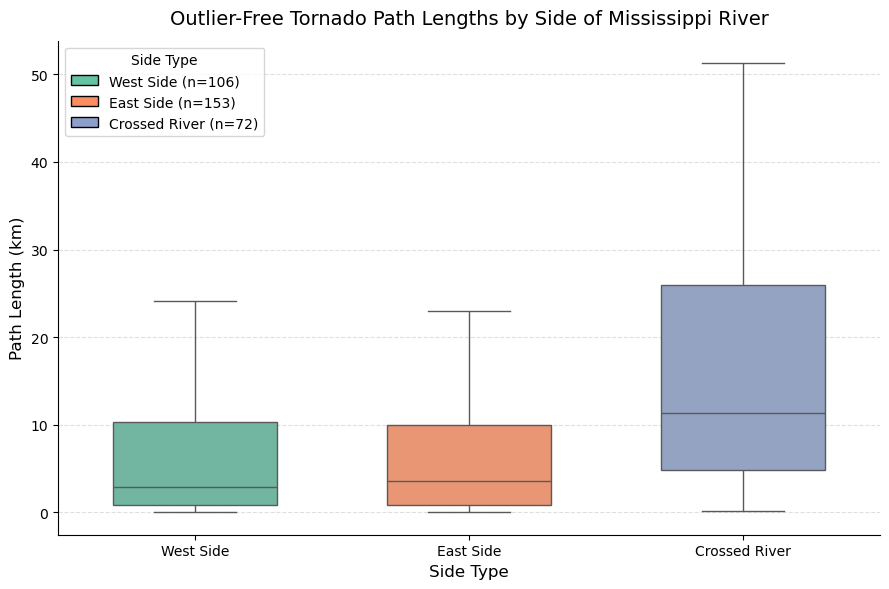

----------------------------------------------------
Total tornadoes in plot: 331
----------------------------------------------------
Five-number summary for path length (km):
                min   25%    50%    75%     max
side_type                                      
Crossed River  0.16  4.85  11.30  25.94  124.88
East Side      0.03  0.80   3.56   9.98   51.03
West Side      0.00  0.82   2.90  10.26  147.25
----------------------------------------------------


In [37]:
# --- Step 1: Prepare filtered subsets by side ---
west_side_plot_f = filtered_plot_df[filtered_plot_df['side_type'] == 'West Side'][['len', 'side_type']]
east_side_plot_f = filtered_plot_df[filtered_plot_df['side_type'] == 'East Side'][['len', 'side_type']]
cross_plot_f     = filtered_plot_df[filtered_plot_df['side_type'] == 'Crossed River'][['len', 'side_type']]

# --- Step 2: Combine into single DataFrame ---
plot_df_f = pd.concat([west_side_plot_f, east_side_plot_f, cross_plot_f], ignore_index=True)

# --- Step 3: Create boxplot ---
plt.figure(figsize=(9, 6))  # slightly wider for spacing
palette = sns.color_palette("Set2", 3)

ax = sns.boxplot(
    data=plot_df_f,
    x="side_type",
    y="len",
    palette=palette,
    showfliers=False,
    width=0.6
)

# --- Step 4: Add color-coded legend with counts ---
counts = plot_df_f["side_type"].value_counts()
legend_elements = [
    Patch(facecolor=palette[i], edgecolor='black',
          label=f"{cat} (n={counts[cat]})")
    for i, cat in enumerate(['West Side', 'East Side', 'Crossed River'])
]

ax.legend(
    handles=legend_elements,
    loc='upper left',
    fontsize=10,
    title="Side Type",
    frameon=True
)

# --- Step 5: Final formatting ---
ax.set_title("Outlier-Free Tornado Path Lengths by Side of Mississippi River", fontsize=14, pad=12)
ax.set_xlabel("Side Type", fontsize=12)
ax.set_ylabel("Path Length (km)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

# --- Step 6: Print summary statistics below the plot ---
total_tornadoes = len(plot_df_f)
summary_stats = plot_df_f.groupby('side_type')['len'].describe()[['min','25%','50%','75%','max']]

print("----------------------------------------------------")
print(f"Total tornadoes in plot: {total_tornadoes}")
print("----------------------------------------------------")
print("Five-number summary for path length (km):")
print(summary_stats.round(2))
print("----------------------------------------------------")

/tmp/ipykernel_105/133983059.py:24: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




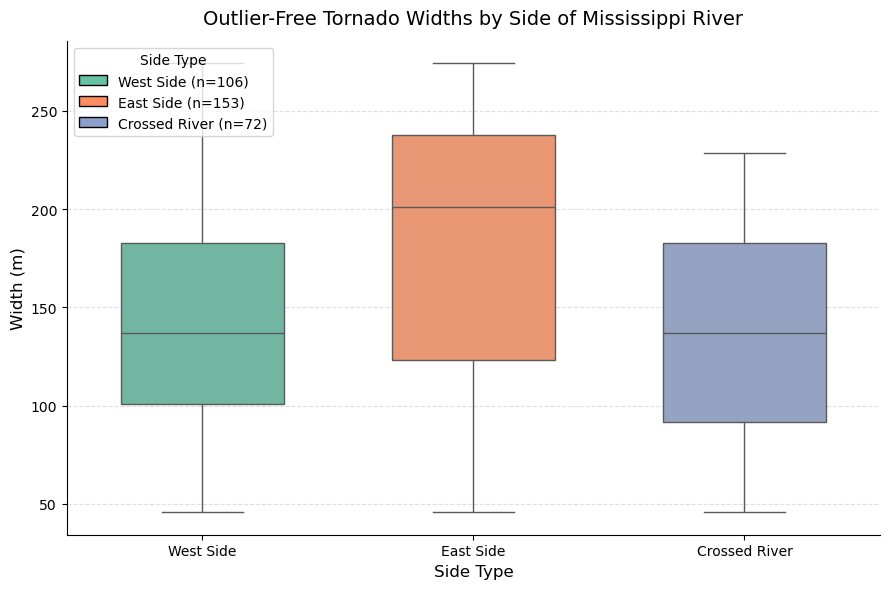

----------------------------------------------------
Total tornadoes in plot: 331
----------------------------------------------------
Five-number summary for tornado width (m):
                 min     25%     50%     75%     max
side_type                                           
Crossed River  45.72   91.44  137.16  182.88  228.60
East Side      45.72  123.44  201.17  237.74  274.32
West Side      45.72  100.58  137.16  182.88  274.32
----------------------------------------------------


In [38]:
# --- Step 0: Merge 'wid' back into filtered_plot_df ---
width_plot_df = filtered_plot_df.merge(
    tornado_gdf[['wid']], 
    left_index=True,
    right_index=True,
    how='left'
)

# --- Step 1: Convert widths from yards to meters ---
width_plot_df['width_m'] = width_plot_df['wid'] * 0.9144

# --- Step 2: Prepare subsets by side ---
west_width_f  = width_plot_df[width_plot_df['side_type'] == 'West Side'][['width_m', 'side_type']]
east_width_f  = width_plot_df[width_plot_df['side_type'] == 'East Side'][['width_m', 'side_type']]
cross_width_f = width_plot_df[width_plot_df['side_type'] == 'Crossed River'][['width_m', 'side_type']]

# --- Step 3: Combine into single DataFrame ---
width_df_f = pd.concat([west_width_f, east_width_f, cross_width_f], ignore_index=True)

# --- Step 4: Boxplot ---
plt.figure(figsize=(9, 6))
palette = sns.color_palette("Set2", 3)

ax = sns.boxplot(
    data=width_df_f,
    x="side_type",
    y="width_m",
    palette=palette,
    showfliers=False,
    width=0.6
)

# --- Step 5: Legend ---
counts = width_df_f["side_type"].value_counts()
legend_elements = [
    Patch(facecolor=palette[i], edgecolor='black',
          label=f"{cat} (n={counts[cat]})")
    for i, cat in enumerate(['West Side', 'East Side', 'Crossed River'])
]
ax.legend(handles=legend_elements, loc='upper left', fontsize=10, title="Side Type", frameon=True)

# --- Step 6: Formatting ---
ax.set_title("Outlier-Free Tornado Widths by Side of Mississippi River", fontsize=14, pad=12)
ax.set_xlabel("Side Type", fontsize=12)
ax.set_ylabel("Width (m)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

# --- Step 7: Five-number summary ---
summary_stats = width_df_f.groupby('side_type')['width_m'].describe()[['min','25%','50%','75%','max']]

print("----------------------------------------------------")
print(f"Total tornadoes in plot: {total_tornadoes}")
print("----------------------------------------------------")
print("Five-number summary for tornado width (m):")
print(summary_stats.round(2))
print("----------------------------------------------------")
#Important to note that outliers were only removed in terms of pathlength by F/EF-scale. No outlying widths were removed after. 

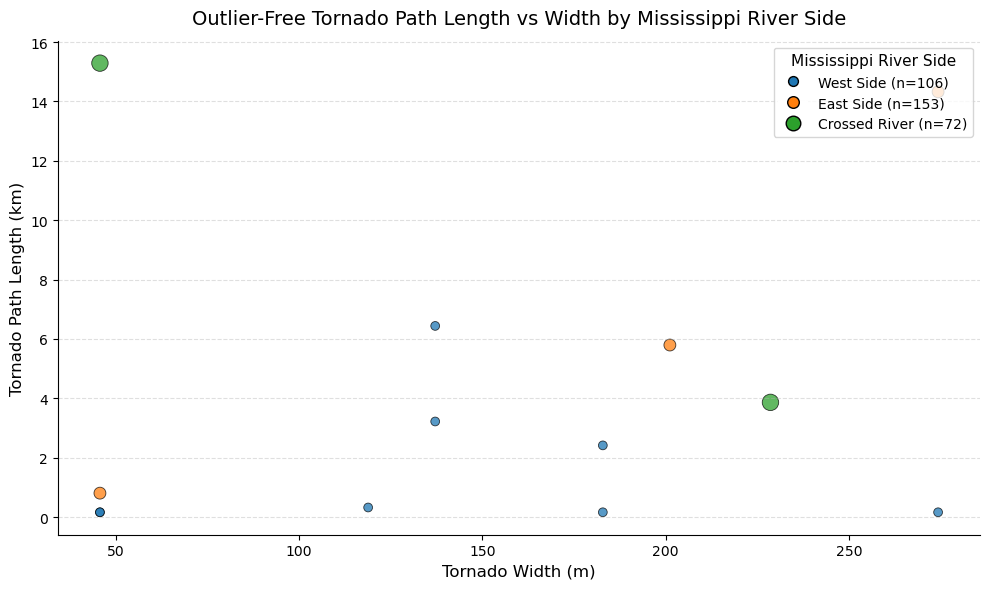

In [39]:
####################################
##Additional Work for Scatterplots##
####################################

# --- Step 0: Merge widths from original tornado_gdf ---
# Use original index to align filtered rows with tornado widths
scatter_df = filtered_plot_df.copy()
scatter_df = scatter_df.merge(
    tornado_gdf[['wid']],
    left_index=True,
    right_index=True,
    how='left'
)

# --- Step 1: Convert widths from yards to meters ---
scatter_df['width_m'] = scatter_df['wid'] * 0.9144

# --- Step 2: Define color palette and point sizes by side type ---
palette = {
    "West Side": "#1f77b4",     # Blue
    "East Side": "#ff7f0e",     # Orange
    "Crossed River": "#2ca02c"  # Green
}

size_map = {
    "West Side": 50,
    "East Side": 70,
    "Crossed River": 110
}
scatter_df['point_size'] = scatter_df['side_type'].map(size_map)

# --- Step 3: Scatter plot ---
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(
    data=scatter_df,
    x='width_m',
    y='len',
    hue='side_type',
    size='point_size',
    sizes=(40, 140),
    palette=palette,
    alpha=0.75,
    edgecolor='black',
    linewidth=0.6,
    legend=False
)

# --- Step 4: Custom legend with counts ---
legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f"{side} (n={sum(scatter_df['side_type']==side)})",
        markerfacecolor=color,
        markersize=np.sqrt(size_map[side]),
        markeredgecolor='black'
    )
    for side, color in palette.items()
]

ax.legend(
    handles=legend_elements,
    title="Mississippi River Side",
    fontsize=10,
    title_fontsize=11,
    loc='upper right',
    frameon=True
)

# --- Step 5: Formatting ---
ax.set_xlabel("Tornado Width (m)", fontsize=12)
ax.set_ylabel("Tornado Path Length (km)", fontsize=12)
ax.set_title(
    "Outlier-Free Tornado Path Length vs Width by Mississippi River Side",
    fontsize=14, pad=12
)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

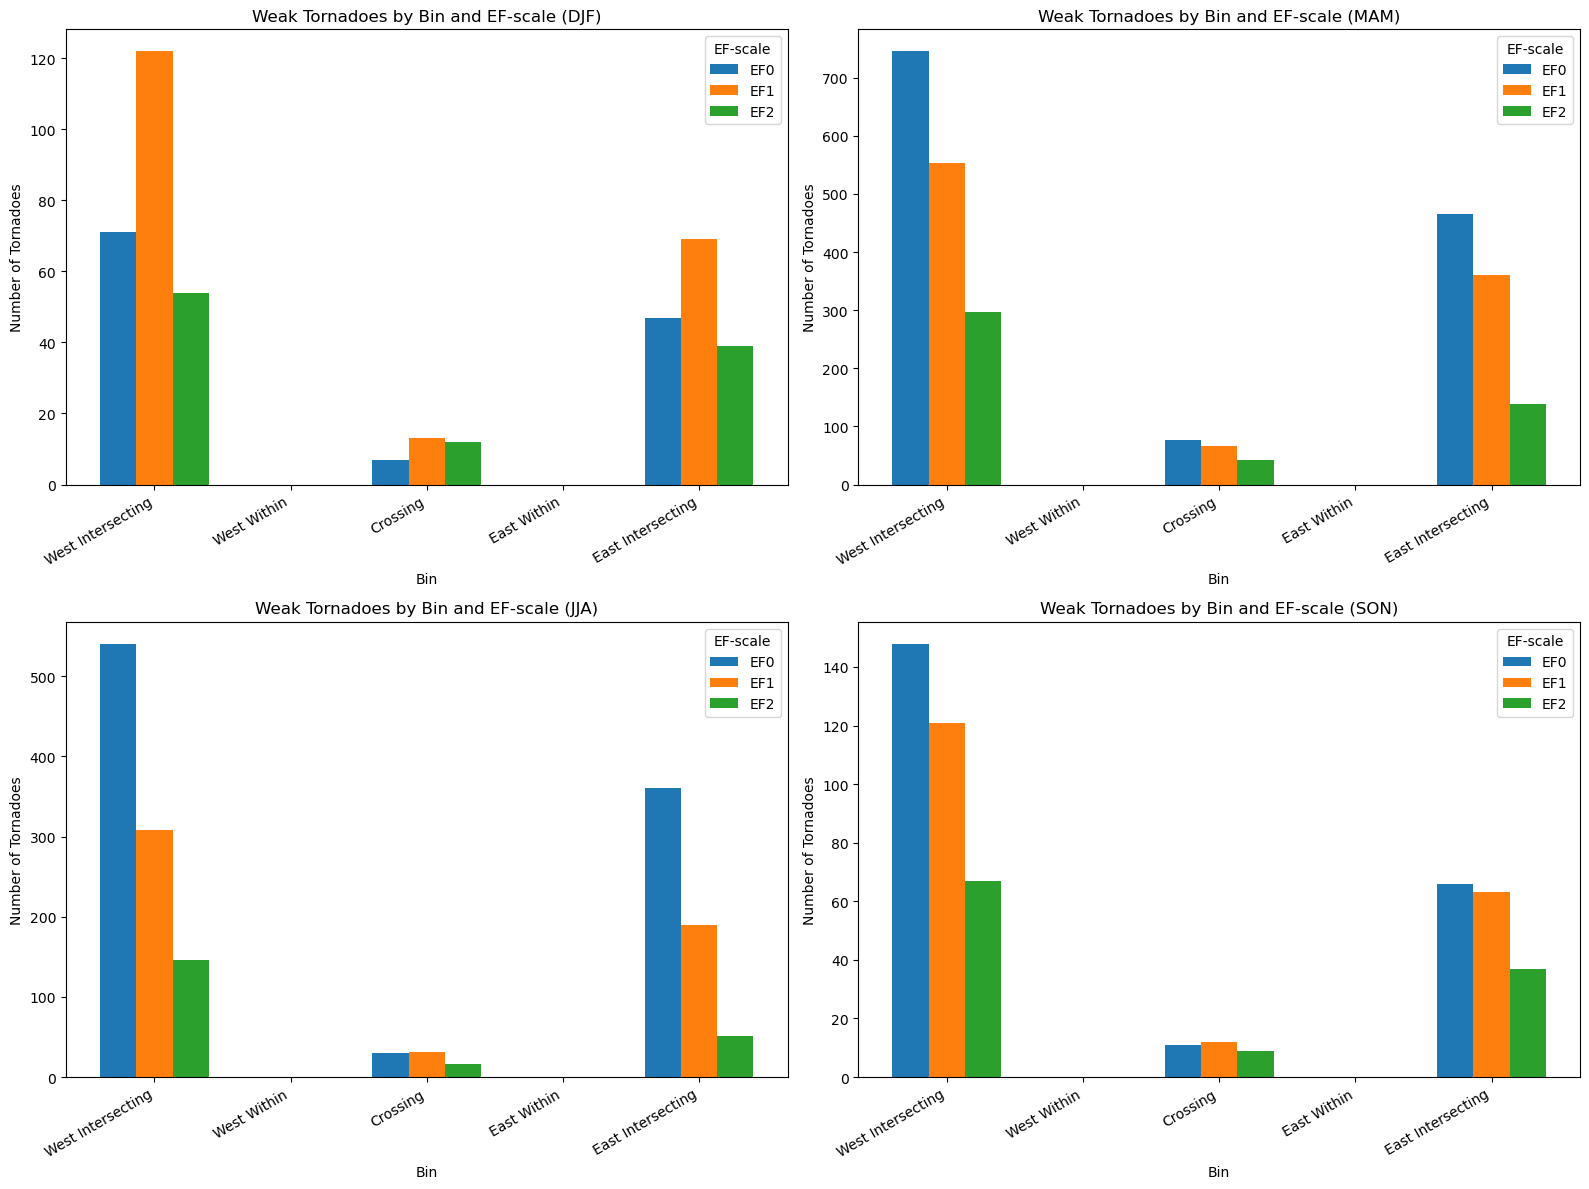

In [38]:
###############################
##Additional Work for Seasons##
###############################

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# --- Step 0: Make sure seasonal column exists ---
tornado_gdf['month'] = tornado_gdf['date'].dt.month
def get_season(month):
    if month in [12, 1, 2]: return 'DJF'
    elif month in [3, 4, 5]: return 'MAM'
    elif month in [6, 7, 8]: return 'JJA'
    else: return 'SON'
tornado_gdf['season'] = tornado_gdf['month'].apply(get_season)

# --- Step 1: Define helper functions ---
def completely_within(geom, buffer_geom):
    """Returns True if both endpoints of a LineString are within buffer_geom, or if a Point is within."""
    from shapely.geometry import Point, LineString, MultiPoint

    if geom.geom_type == 'Point':
        return buffer_geom.contains(geom)
    elif geom.geom_type == 'LineString':
        # Extract boundary points safely
        b = geom.boundary
        if isinstance(b, Point):
            pts = [b]
        elif isinstance(b, MultiPoint):
            pts = list(b.geoms)
        else:
            pts = list(b)  # fallback
        return all(buffer_geom.contains(pt) for pt in pts)
    return False

# Step 2: Pre-compute bins for all tornadoes (so seasonal plots match all-season bins)
west_side = tornado_gdf[(tornado_gdf['crosses_river']==False) & (tornado_gdf['geometry'].apply(lambda g: g.centroid.x < river_il_geom.centroid.x))]
east_side = tornado_gdf[(tornado_gdf['crosses_river']==False) & (tornado_gdf['geometry'].apply(lambda g: g.centroid.x > river_il_geom.centroid.x))]
crossing = tornado_gdf[tornado_gdf['crosses_river']==True]

# Compute intersecting vs within for west and east
west_within = west_side[west_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
west_intersecting = west_side[~west_side.index.isin(west_within.index)]
east_within = east_side[east_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
east_intersecting = east_side[~east_side.index.isin(east_within.index)]

# --- Step 3: Prepare seasonal counts per bin per EF-scale ---
bins_dict = {
    'West Intersecting': west_intersecting,
    'West Within': west_within,
    'Crossing': crossing,
    'East Within': east_within,
    'East Intersecting': east_intersecting
}

seasons = ['DJF', 'MAM', 'JJA', 'SON']
ef_scales = [0, 1, 2]

# --- Step 4: Plot ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, season in enumerate(seasons):
    ax = axes[i]
    counts = []
    for bin_name, gdf_bin in bins_dict.items():
        season_bin = gdf_bin[gdf_bin['season']==season]
        ef_counts = [season_bin[season_bin['mag']==ef].shape[0] for ef in ef_scales]
        counts.append(ef_counts)
    
    counts_df = pd.DataFrame(counts, index=bins_dict.keys(), columns=[f'EF{ef}' for ef in ef_scales])
    counts_df.plot(kind='bar', stacked=False, ax=ax, width=0.8)
    
    ax.set_title(f"Weak Tornadoes by Bin and EF-scale ({season})", fontsize=12)
    ax.set_ylabel("Number of Tornadoes")
    ax.set_xlabel("Bin")
    ax.legend(title="EF-scale")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()